In [27]:
from dotenv import load_dotenv

load_dotenv()

True

In [28]:
import os
import shutil
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.docstore.document import Document
from langchain_community.document_loaders import PyPDFLoader, TextLoader
from typing import Literal, Optional

# 메모리 컨텍스트 저장 변수
stored_resume: Optional[str] = None
stored_jd: Optional[str] = None
base_chain_inputs: Optional[dict] = None
# RAG 벡터 스토어
vectorstore: Optional[Chroma] = None
# 영속 디렉토리 설정 (환경변수 또는 기본 경로)
persist_directory = os.getenv(
    "CHROMA_DB_PATH",
    os.path.join(os.getcwd(), "rag_agent/vectorstore/chroma_db")
)


# 로컬 파일 시스템에서 context와 회사 자료 자동 로딩
# TODO: RAG PyPDF2 -> langchain vector db
def parse_file_to_text(file_path: str) -> str:
    with open(file_path, "rb") as f:
        content = f.read()
    try:
        return content.decode("utf-8")
    except UnicodeDecodeError:
        if file_path.lower().endswith(".pdf"):
            loader = PyPDFLoader(file_path)
            docs = loader.load()
            return "\n".join(doc.page_content for doc in docs)
        elif file_path.lower().endswith((".docx", ".doc", ".txt")):
            loader = TextLoader(file_path)
            docs = loader.load()
            return "\n".join(doc.page_content for doc in docs)
        else:
            return content.decode("utf-8", errors="ignore")
        
def get_company_info():
    # 회사 자료 검색
    retrieved = vectorstore.similarity_search(stored_jd, k=3)
    company_info = "\n".join([doc.page_content for doc in retrieved])
    # Trim company_info to avoid exceeding model context window
    max_company_info_length = 2000
    if len(company_info) > max_company_info_length:
        company_info = company_info[:max_company_info_length]
    return company_info


base_dir = os.path.join(os.getcwd(), "data")
# 이력서 로딩
resume_dir = os.path.join(base_dir, "resume")
for fname in os.listdir(resume_dir):
    stored_resume = parse_file_to_text(os.path.join(resume_dir, fname))
    break
# JD 로딩
jd_dir = os.path.join(base_dir, "jd")
for fname in os.listdir(jd_dir):
    stored_jd = parse_file_to_text(os.path.join(jd_dir, fname))
    break
# 회사 자료 로딩 및 인덱싱
company_dir = os.path.join(base_dir, "company_infos")
docs = []
for fname in os.listdir(company_dir):
    text = parse_file_to_text(os.path.join(company_dir, fname))
    splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
    for chunk in splitter.split_text(text):
        docs.append(Document(page_content=chunk, metadata={"filename": fname}))
embeddings = OpenAIEmbeddings()
vectorstore = Chroma(
    persist_directory=persist_directory, embedding_function=embeddings
)
stored_company_info = get_company_info()
base_chain_inputs = {
    "resume": stored_resume,
    "jd": stored_jd,
    "company_infos": stored_company_info,
}
if docs:
    texts = [d.page_content for d in docs]
    metadatas = [d.metadata for d in docs]
    vectorstore.add_texts(texts=texts, metadatas=metadatas)
    vectorstore.persist()

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


In [29]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from rag_agent import ChatHistory

class AgentState(TypedDict):
    query: str # 사용자 답변
    answer: str # Agent 답변
    input_type: str # 사용자 답변 유형
    persona_id: str # 페르소나 ID
    route_type: str # routing 결과
    resume: str # 자소서(이력서)
    jd: str # 채용공고
    company: str # 회사정보 (인재상)
    chat_history: ChatHistory # 대화내역
    last_question: str #마지막 질문
    
graph_builder = StateGraph(AgentState)

In [30]:
from langgraph.graph import MessagesState
from langgraph.types import Command
from typing import Literal
from langchain_core.messages import HumanMessage
from langchain_community.tools.yahoo_finance_news import YahooFinanceNewsTool
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import create_react_agent
from langchain_community.agent_toolkits.polygon.toolkit import PolygonToolkit
from langchain_community.utilities.polygon import PolygonAPIWrapper

import os

llm = ChatOpenAI(
    api_key=os.getenv("OPENAI_API_KEY"), temperature=0.7, model_name="gpt-4o-mini"
)


In [31]:
classify_agent = create_react_agent(
  llm,
  tools=[],
  prompt=""""
  주어진 입력이 어떤 유형인지 판단하세요: 
  - 자소서 입력 (resume)
  - 질문 요청 (question)
  - 꼬리질문 요청 (followup)
  - 모범 답변 요청 (modelAnswer)
  - 답변 (answer)
  - 그 외 일반 텍스트 (other)

  형식: resume, question, followup, modelAnswer, answer, other 중 하나로만 답하세요.
  """
)

def classify_input(state: AgentState) -> AgentState:
    """
    사용자 입력과, 이전 대화내용을 바탕으로 현재 입력이 어떤 형식인지 분류하고,
    결과를 router node로 전달합니다.
    
    Args:
      state (MessageState): 현재 메시지 상태를 나타내는 객체입니다.
    
    Returns:
      Command: router node로 이동하기 위한 명령을 반환합니다.
    """
    result = classify_agent.invoke({ input: state['query'] })
    print("classify_input", result['messages'])
    # 분류 결과 추출 (마지막 메시지의 content가 분류값)
    classification = result['messages'][-1].content.strip()
    
    # 결과 메시지를 업데이트하고 router node로 이동합니다.
    return { "input_type": classification }

In [32]:
from rag_agent import PersonaService
from rag_agent.persona.Persona import Persona, PersonaType
from rag_agent.persona.PersonaService import PersonaInput

persona_service = PersonaService.get_instance()
persona_service.set_context(stored_resume, stored_jd)
# 페르소나 추가 (테스트용)
persona_service.add_persona(
    PersonaInput(
        name="Recruiter",
        type="other",
        interests=["조직 적응력", "인성"],
        communicationStyle="차분하고 상냥한 스타일",
    )
)
persona_service.add_persona(
    PersonaInput(
        name="CTO",
        type="developer",
        interests=["이슈 해결 과정과 Lessons Learned"],
        communicationStyle="불필요한 말은 하지 않음, 합리적이고 이성적인 스타일",
    )
)

# 이거 대신 persona_service 인스턴스 사용
# assign_persona_agent = create_react_agent(
#     llm,
#     tools=[],
#     state_modifier="You are an HR specialist. Select the best interviewer persona for the provided context. Output only the persona id."
# )

def assign_persona_node(state: AgentState) -> AgentState:
    """
    페르소나 할당 node입니다. 주어진 state를 기반으로 assign_persona 에이전트를 호출하고,
    결과를 router node로 전달합니다.

    Args:
        state (MessagesState): 현재 메시지 상태 객체.

    Returns:
        Command: router node로 이동 명령을 반환.
    """
    persona_id = persona_service.invoke_agent(state)
    print("assign_persona_node", persona_id)
    
    return { "persona_id": persona_id }
    

In [33]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Literal

class Route(BaseModel):
    target: Literal['generate_question', 'generate_model_answer', 'generate_followup', 'llm'] = Field(
        description="The target for the query to answer"
    )

router_system_prompt = """
You are an expert at routing a user's question to 'generate_question', 'generate_model_answer', 'generate_followup' or 'llm'.
'generate_question' contains information about resume, company, jd.
'generate_model_answer' contains information about last question and context(company, resume, jd).
'generate_followup' contains information about last question and applicant's answer.
if you think the question is not related to either 'generate_question', 'generate_model_answer' or 'generate_followup';
you can route it to 'llm'."""


router_prompt = ChatPromptTemplate.from_messages([
    ('system', router_system_prompt),
    ('user', '{query}')
])

small_llm = ChatOpenAI(
    api_key=os.getenv("OPENAI_API_KEY"), temperature=0.7, model_name="gpt-4o-mini"
)

structured_router_llm = small_llm.with_structured_output(Route)

def router(state: AgentState) -> AgentState:
    """
    주어진 state에서 쿼리를 기반으로 적절한 경로를 결정합니다.

    Args:
        state (AgentState): 현재 에이전트의 state를 나타내는 객체입니다.

    Returns:
        Literal['generate_question', 'generate_model_answer', 'generate_followup', 'llm']: 쿼리에 따라 선택된 경로를 반환합니다.
    """
    query = state['query']
    router_chain = router_prompt | structured_router_llm 
    route = router_chain.invoke({'query': query})
    print("router", route)

    return { "route_type": route.target }



In [34]:
from langchain.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_core.tools import tool

from typing import TypedDict, List, Dict, Any
import json

@tool
def generate_interview_question(data: str) -> str:
    """자소서, JD, 회사 정보를 기반으로 면접 질문을 생성합니다."""
    try:
        parsed_data = json.loads(data)
        resume = parsed_data.get("resume", "")
        jd = parsed_data.get("jd", "")
        company = parsed_data.get("company", "")
        persona = parsed_data.get("persona", "")
    except json.JSONDecodeError:
        return "입력 데이터 형식이 올바르지 않습니다. JSON 형식으로 제공해주세요."

    generation_prompt = PromptTemplate.from_template(
        """
        다음은 지원자의 자소서, JD(직무기술서), 회사 정보, 그리고 면접관 페르소나입니다:

        자기소개서:
        {resume}

        JD:
        {jd}

        회사 정보:
        {company}

        면접관 페르소나:
        {persona}

        당신은 위 페르소나를 기반으로 하는 면접관입니다.
        다음 단계를 거쳐 면접 질문을 생성하세요:

        1단계 - 분석 (Reasoning):
        - 회사 인재상에 부합하는 성격/역량/행동을 자소서에서 얼마나 확인할 수 있는가?
        - JD에서 요구하는 자격요건, 기술, 경험과 자소서가 얼마나 부합하는가?
        - 부족하거나 확인이 필요한 부분은 무엇인가?
        - 면접관 페르소나의 시각과 말투, 성격을 반영한 분석

        2단계 - 질문 생성 (Acting):
        - 1단계 분석을 바탕으로 구체적이고 답변 가능한 면접 질문 1개를 생성
        - 면접관 페르소나의 말투와 스타일을 반영

        출력 형식:
        분석:
        [분석 내용]

        질문:
        [생성된 면접 질문]
        """
    )

    chain = generation_prompt | llm | StrOutputParser()
    return chain.invoke({
        "resume": resume, 
        "jd": jd, 
        "company": company, 
        "persona": persona
    })

def generation(state: AgentState) -> AgentState:
    """면접 질문을 생성하는 노드"""
    try:
        # 상태에서 필요한 정보 추출
        resume = state.get("resume", "")
        jd = state.get("jd", "")
        company = state.get("company", "")
        persona = state.get("persona", "")
        
        # 데이터를 JSON 형태로 준비
        input_data = json.dumps({
            "resume": resume,
            "jd": jd,
            "company": company,
            "persona": persona
        }, ensure_ascii=False)
        
        # 통합된 tool을 사용하여 질문 생성
        result = generate_interview_question.invoke(input_data)
        print("generation", result)
        
        # 결과를 상태에 업데이트
        return {
            "answer": result
        }
        
    except Exception as e:
        return {
            "error": f"Generation 노드에서 오류 발생: {str(e)}",
            "status": "error",
            "messages": state.get("messages", []) + [
                {"role": "system", "content": f"오류: {str(e)}"}
            ]
        }


In [35]:
def conditional_router(state: AgentState) -> str:
    """
    그래프의 조건부 엣지에서 사용할 라우팅 함수
    
    Args:
        state (AgentState): 현재 상태
        
    Returns:
        str: 다음 노드 이름
    """
    # 상태에서 라우팅 정보 확인
    print(state)
    next_route = state.get('next_route', 'other')
    
    # 그래프 노드 이름과 매핑
    route_mapping = {
        'generation': 'Generation',
        'question': 'Generation',
        'answer': 'Generation',
        'model_answer': 'ModelAnswer', 
        'interview_answer': 'EvaluateFollowup',
        'other': 'SmallLLM'
    }
    
    return route_mapping.get(next_route, 'SmallLLM')

In [36]:
from langgraph.graph import START, END
    
graph_builder = StateGraph(AgentState)

# 노드 추가
graph_builder.add_node('classify_input', classify_input)
graph_builder.add_node('assign_persona', assign_persona_node)
graph_builder.add_node('router', router)
graph_builder.add_node('generation', generation)

# 시작점에서 병렬 실행
graph_builder.add_edge(START, 'classify_input')
graph_builder.add_edge(START, 'assign_persona')

# 두 병렬 노드가 완료되면 라우터로
graph_builder.add_edge('classify_input', 'router')
graph_builder.add_edge('assign_persona', 'router')

# 생성 노드에서 종료
graph_builder.add_edge('generation', END)

graph_builder.add_conditional_edges(
    'router',
    conditional_router,
    ['generation']
)

In [37]:
graph = graph_builder.compile()

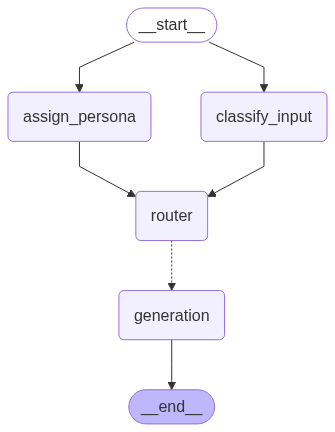

In [38]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [40]:
initial_state = { 'query': """
### 토스의 문화를 이해하고 기술로 뒷받침하는 개발자

토스의 "고객을 위한 최선의 선택"이라는 문화에 깊이 공감하며, 이러한 문화가 내부 시스템에서부터 시작된다고 믿습니다. 지난 3년간 Python과 Django를 기반으로 복잡한 비즈니스 문제를 기술로 해결해온 경험을 바탕으로, 토스팀의 생산성 향상과 문화 발전에 기여하고 싶습니다.

### 비즈니스 문제를 기술로 해결한 경험

현재 회사에서 월 100시간이 소요되던 수동 재고 관리 프로세스를 관찰한 결과, 단순 반복 작업과 외부 시스템 간 데이터 불일치가 주요 문제였습니다. 

**문제 해결 과정:**
1. **문제 분석**: 업무 담당자와의 지속적인 소통을 통해 pain point 파악
2. **기술적 설계**: Django의 Command 패턴과 Celery를 활용한 비동기 처리 아키텍처 설계
3. **점진적 개선**: MVP 접근법으로 핵심 기능부터 구현하여 빠른 피드백 수집
4. **지속적 최적화**: 사용자 피드백을 바탕으로 기능 개선 및 확장

결과적으로 업무 시간을 80% 단축시켰고, 더 중요한 것은 팀원들이 반복 업무에서 벗어나 더 가치 있는 일에 집중할 수 있게 되었습니다.

### 기술적 성장에 대한 갈망

기술적 완벽함보다는 **상황에 맞는 최선의 선택**을 추구합니다. 

예를 들어, 실시간 알림 시스템 구축 시 WebSocket이 기술적으로 더 우아한 해결책이었지만, 팀의 운영 역량과 인프라 현황을 고려하여 Polling 방식으로 시작했습니다. 이후 시스템이 안정화되고 팀 역량이 향상된 후 단계적으로 WebSocket으로 마이그레이션하여 무중단 업그레이드를 달성했습니다.

이런 경험을 통해 **기술적 이상보다는 비즈니스 가치 창출**이 우선되어야 함을 체득했습니다.

### 조직 문화에 대한 관심과 기여

개발자가 만드는 도구는 결국 사람이 사용하는 것이기에, 조직 문화를 깊이 이해해야 한다고 생각합니다. 

현재 회사에서 사내 업무 자동화 플랫폼을 개발하며 다음과 같은 문화적 요소들을 고려했습니다:
- **투명성**: 모든 작업 과정을 슬랙으로 실시간 공유
- **협업**: 비개발자도 쉽게 사용할 수 있는 직관적 UI 설계
- **자율성**: 각 팀이 자신들의 워크플로우를 스스로 정의할 수 있는 유연한 구조

이런 노력이 결실을 맺어 전사 생산성 향상 프로젝트에서 '올해의 혁신상'을 수상하기도 했습니다.                 
""" }
graph.invoke(initial_state)


[DEBUG] Persona query: {'job_description': 'Python Developer\r\n\r\n토스 소속 | 정규직\r\n\r\n합류하게 될 팀에 대해 알려드려요\r\n\r\n토스의 Python Developer는 Product Designer, Product Manager와 함께 협업하고 있고, Internal Platform Team과 Toss One Team에 속해 있어요.\r\nInternal Platform Team에서는 토스의 문화를 지탱하고 생산성을 향상시키는 다양한 웹 서비스를 개발해요.\r\n손으로 작업하는 수많은 유즈 케이스를 자동화하고, 시스템이 대신 수행해줄 수 있도록 도구들을 개발해요.\r\n요청, 결제, 처리 프로세스를 유연하게 구성하고 처리할 수 있는 시스템을 개발해요.\r\n마이크로 서비스로 개별 구성되는 어드민 서비스가 빠르게 구현될 수 있도록 돕는 프레임워크를 개발해요.\r\n토스 내부 컨텐츠를 누구나 빠르게 작성하고 배포할 수 있는 시스템을 개발해요.\r\nToss One Team에서는 토스 계열사 전체를 위한 통합 상담 시스템을 개발하고 있어요.\r\n중요한 고객 개인정보를 다루는 서비스이기에 높은 보안 요건들을 충족시키기 위한 도구를 개발하고 있어요.\r\n\r\n합류하면 함께할 업무예요\r\n\r\n토스 계열사 전체에 배포되는 인터널 시스템의 빌드, 배포 파이프라인을 구축하고 운영해요.\r\n직접 만든, 50개 이상의 내부 제품 고도화와 운영 효율화를 담당하고 있어요.\r\n수기로 관리하던 것을 자동화하거나, 토스 외부의 시스템과 연계하여 복잡도 높은 시스템을 구성하고 개발해요.\r\n복잡한 정책과 디자인 시안을 기반으로 요구 사항에 적절한 설계를 빠르게 구현하고 배포해요.\r\n\r\n이런 분과 함께하고 싶어요\r\n\r\n토스팀 문화를 수호하기 위해서는 업무 툴을 만드는 사람들 또한 팀 문화를 온전히 이해해야 해요. 조직문화에 대한 관심이 많고, 관찰을 통해 문화를 주도적으로 이끌어 나가고자

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


classify_input [AIMessage(content='other', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 1, 'prompt_tokens': 102, 'total_tokens': 103, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BhEfaOhT7FTxZnbqKt9Ki3XuhnAOK', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--ac64468c-1096-43ed-811c-4ccebfd93794-0', usage_metadata={'input_tokens': 102, 'output_tokens': 1, 'total_tokens': 103, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


<class 'langgraph.utils.pydantic.LangGraphInput'>
[DEBUG] Agent result: {'messages': [AIMessage(content='Please provide the relevant information for me to analyze and select the most appropriate interviewer persona ID.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 109, 'total_tokens': 127, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-BhEfaZDpUWcWa2itAtDF03an0tz0C', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--336259d9-b5d2-423e-8629-bef3e72f3c29-0', usage_metadata={'input_tokens': 109, 'output_tokens': 18, 'total_tokens': 127, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


router target='generate_question'
{'query': '\n### 토스의 문화를 이해하고 기술로 뒷받침하는 개발자\n\n토스의 "고객을 위한 최선의 선택"이라는 문화에 깊이 공감하며, 이러한 문화가 내부 시스템에서부터 시작된다고 믿습니다. 지난 3년간 Python과 Django를 기반으로 복잡한 비즈니스 문제를 기술로 해결해온 경험을 바탕으로, 토스팀의 생산성 향상과 문화 발전에 기여하고 싶습니다.\n\n### 비즈니스 문제를 기술로 해결한 경험\n\n현재 회사에서 월 100시간이 소요되던 수동 재고 관리 프로세스를 관찰한 결과, 단순 반복 작업과 외부 시스템 간 데이터 불일치가 주요 문제였습니다. \n\n**문제 해결 과정:**\n1. **문제 분석**: 업무 담당자와의 지속적인 소통을 통해 pain point 파악\n2. **기술적 설계**: Django의 Command 패턴과 Celery를 활용한 비동기 처리 아키텍처 설계\n3. **점진적 개선**: MVP 접근법으로 핵심 기능부터 구현하여 빠른 피드백 수집\n4. **지속적 최적화**: 사용자 피드백을 바탕으로 기능 개선 및 확장\n\n결과적으로 업무 시간을 80% 단축시켰고, 더 중요한 것은 팀원들이 반복 업무에서 벗어나 더 가치 있는 일에 집중할 수 있게 되었습니다.\n\n### 기술적 성장에 대한 갈망\n\n기술적 완벽함보다는 **상황에 맞는 최선의 선택**을 추구합니다. \n\n예를 들어, 실시간 알림 시스템 구축 시 WebSocket이 기술적으로 더 우아한 해결책이었지만, 팀의 운영 역량과 인프라 현황을 고려하여 Polling 방식으로 시작했습니다. 이후 시스템이 안정화되고 팀 역량이 향상된 후 단계적으로 WebSocket으로 마이그레이션하여 무중단 업그레이드를 달성했습니다.\n\n이런 경험을 통해 **기술적 이상보다는 비즈니스 가치 창출**이 우선되어야 함을 체득했습니다.\n\n### 조직 문화에 대한 관심과 기여\n\n개발자가 만드는 도구는 결국 사람이 사용하는 것

KeyError: 'SmallLLM'